# CQF EXAM3 Report 

## **1. Introduction & Methodological Framework**

#### **1.1. Research Objective**
This report presents a rigorous, structured investigation into the predictability of short-term (daily) positive returns for the SPDR S&P 500 ETF (SPY), a proxy for the broad U.S. equity market. The primary objective is to construct and critically evaluate a supervised machine learning model based on historical price and volume data, in accordance with the requirements of the CQF Exam Three.

#### **1.2. Methodological Framework**
The analysis follows a systematic quantitative research workflow, designed to ensure methodological rigor and reproducibility. The core framework is as follows:

1.  **Theoretical Foundation (Part A):** We begin by addressing foundational mathematical and machine learning concepts to establish a theoretical basis for our subsequent empirical work.
2.  **Data-Driven Feature Hypothesis (Part B):** We operate on the hypothesis that historical market data contains non-random patterns (or "signals") that may have predictive power. We will engineer a comprehensive set of technical indicators to represent these potential patterns numerically.
3.  **Systematic Feature Reduction (Part B):** Recognizing that a large feature set can lead to model overfitting and include significant noise, we employ a multi-stage "funneling" methodology. This approach systematically distills a vast feature library into a parsimonious and potent subset of predictors.
4.  **Robust Model Training and Validation (Part C):** A Support Vector Machine (SVM) is selected as the core classification algorithm. Crucially, model hyperparameter tuning is conducted using a time-series-aware cross-validation scheme (`TimeSeriesSplit`) to prevent lookahead bias and ensure the model's out-of-sample performance is estimated robustly.
5.  **Multi-Faceted Performance Evaluation (Part C):** The model's efficacy is assessed not only through standard statistical metrics (e.g., AUC, Precision, Recall) but also through its practical economic significance, evaluated via a simplified trading strategy backtest.


## **2.Part A: Mathematical Questions**

### **2.1 Gaussian RBF Kernel (Q1)**

**Answer**:

The correct option is **(a) $k(z_1, x)$ will be close to 1 and $k(z_2, x)$ will be close to 0**.

**Explanation:**

The Gaussian Radial Basis Function (RBF) kernel is a widely used kernel function in Support Vector Machines (SVMs). Its primary purpose is to measure the similarity between two data points in a high-dimensional feature space. The function's value ranges from 0 (dissimilar) to 1 (identical).

Let's analyze the formula's components:
-   $||x_i - x_j||^2$: This is the squared Euclidean distance between points $x_i$ and $x_j$. It's a direct measure of their separation in the feature space.
-   $\sigma$ (sigma): This is a hyperparameter that acts as a scaling factor, defining the "width" or "reach" of the kernel. It controls how far a single training example's influence spreads.

**Case 1: $k(z_1, x)$ where $z_1$ is very close to $x$**
1.  **Distance**: Because $z_1$ and $x$ are geometrically very close, the distance between them, $||z_1 - x||$, approaches 0.
2.  **Exponent Calculation**: Consequently, the numerator of the fraction, $||z_1 - x||^2$, also approaches 0. This makes the entire exponent term, $-\frac{||z_1 - x||^2}{2\sigma^2}$, approach 0.
3.  **Kernel Value**: The kernel value becomes $k(z_1, x) \approx exp(0)$, which is equal to 1. A value of 1 signifies the highest possible similarity, which aligns with the fact that the points are very close.

**Case 2: $k(z_2, x)$ where $z_2$ is far away from $x$**
1.  **Distance**: Because $z_2$ and $x$ are geometrically far apart, the distance between them, $||z_2 - x||$, is a large positive number.
2.  **Exponent Calculation**: The squared distance, $||z_2 - x||^2$, becomes a very large positive number. This makes the exponent term, $-\frac{||z_2 - x||^2}{2\sigma^2}$, a large-magnitude negative number (i.e., it approaches $-\infty$).
3.  **Kernel Value**: The kernel value becomes $k(z_2, x) \approx exp(-\text{large number})$, which approaches 0. A value of 0 signifies minimal similarity, which is consistent with the points being far apart.

### **2.2 Voting Classifiers in Ensemble Learning (Q2)**


**Answer**:

A Voting Classifier is a meta-algorithm in ensemble learning that combines the predictions from multiple, independently trained machine learning models (referred to as base classifiers) to produce a single, final prediction. The fundamental principle is the "wisdom of the crowd": the collective decision of a diverse group of models is typically more accurate, robust, and less prone to overfitting than any individual model.

A Voting Classifier works by aggregating the outputs of its constituent models. This aggregation can be done in two primary ways:

**1. Hard Voting (Majority Rule Voting)**
-   **Mechanism**: This is the simplest form of voting. For a given input, each base classifier predicts a class label. The Voting Classifier then selects the class label that was predicted by the majority of the models.
-   **Analogy**: It works like a democratic election where each model gets one vote, and the class with the most votes wins.
-   **Use Case**: Hard voting is effective when the ensemble consists of diverse models with comparable performance levels. It reduces variance by canceling out the individual errors of the base models.

**2. Soft Voting (Averaged Probabilities Voting)**
-   **Mechanism**: This method is more nuanced. It requires that the base classifiers can output a probability for each class (e.g., via a `predict_proba()` method). The Voting Classifier then calculates the average of the probabilities predicted by all models for each class. The final prediction is the class with the highest average probability. It is also possible to assign different weights to each classifier based on their perceived importance or performance.
-   **Analogy**: This is like a weighted election where each model's vote is weighted by its "confidence" (predicted probability). A model that is highly confident in its prediction has a greater influence on the final outcome.
-   **Use Case**: Soft voting is generally preferred over hard voting as it leverages more information from each model. By considering the confidence of each prediction, it often leads to a more accurate final classification, especially when the base models are well-calibrated.

In summary, Voting Classifiers are a powerful and straightforward ensemble technique used to improve model generalization and reduce prediction errors by combining the strengths of multiple different algorithms.

## **3. Part B: Feature Selection Using the Funnelling Approach**

### **3.1. Data Preparation and Feature Engineering**

The premise of technical analysis is that historical market data contains information about future price movements. Our objective in this section is to transform this raw data into a structured feature set that a machine learning algorithm can interpret. We define our binary target variable, a significant positive return, and then construct **41** technical indicators from the base OHLCV data. Raw price series are non-stationary and difficult for many models to learn from directly. By converting them into stationary indicators (like returns and oscillators), we create a feature space more amenable to statistical learning. This rich and diverse feature set provides the necessary "raw material" for our feature selection algorithms, increasing the probability of discovering genuine predictive signals.

In [35]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# --- 3.1 Data Preparation and Feature Engineering ---
df = pd.read_csv('spy_5_years.csv', parse_dates=['Date'], index_col='Date')

# Define target variable
df['Return'] = df['Close'].pct_change()
df['Direction'] = (df['Return'].shift(-1) > 0.0025).astype(int)

# --- Standard Feature Pool ---
for i in range(1, 6): df[f'Return_{i}'] = df['Return'].shift(i)
for sma in [5, 10, 20, 50, 200]: df[f'SMA_{sma}'] = df['Close'].rolling(window=sma).mean()
for ema in [5, 10, 20, 50, 200]: df[f'EMA_{ema}'] = df['Close'].ewm(span=ema, adjust=False).mean()
delta = df['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()

df['RSI'] = 100 - (100 / (1 + (gain / loss)))
ema_12 = df['Close'].ewm(span=12, adjust=False).mean()
ema_26 = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = ema_12 - ema_26
df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
df['MACD_Hist'] = df['MACD'] - df['MACD_Signal']
low_14 = df['Low'].rolling(window=14).min()
high_14 = df['High'].rolling(window=14).max()
df['%K'] = 100 * ((df['Close'] - low_14) / (high_14 - low_14))
df['%D'] = df['%K'].rolling(window=3).mean()
df['Volatility_10'] = df['Return'].rolling(window=10).std()
df['Volatility_20'] = df['Return'].rolling(window=20).std()
df['BB_Middle'] = df['Close'].rolling(window=20).mean()
df['BB_Upper'] = df['BB_Middle'] + 2 * df['Close'].rolling(window=20).std()
df['BB_Lower'] = df['BB_Middle'] - 2 * df['Close'].rolling(window=20).std()
df['OBV'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()
for vma in [5, 10, 20]: df[f'VMA_{vma}'] = df['Volume'].rolling(window=vma).mean()
df['Price_SMA200_Ratio'] = df['Close'] / df['SMA_200']
df['RSI_Volatility_Interaction'] = df['RSI'] * df['Volatility_10']
df['SMA_Diff'] = df['SMA_10'] - df['SMA_50']

# Price Structure Features
df['Trend_Strength_SMA'] = df['SMA_10'] - df['SMA_50']
df['is_breakout_20d'] = (df['Close'] > df['High'].rolling(20).max().shift(1)).astype(int)

# Clean NaN values and prepare feature matrix X and target vector y
df.dropna(inplace=True)
X = df.drop(['Direction', 'Return'], axis=1)
y = df['Direction']

 #Data Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

print(f"Feature engineering complete. Initial feature count: {X.shape[1]}")
print(X.head())

Feature engineering complete. Initial feature count: 41
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2016-02-11  182.339996  184.100006  181.089996  182.860001  168.137314   
2016-02-12  184.960007  186.649994  183.960007  186.630005  171.603775   
2016-02-16  188.770004  189.809998  187.630005  189.779999  174.500122   
2016-02-17  191.160004  193.320007  191.009995  192.880005  177.350540   
2016-02-18  193.199997  193.270004  191.720001  192.089996  176.624146   

               Volume  Return_1  Return_2  Return_3  Return_4  ...  \
Date                                                           ...   
2016-02-11  219058900 -0.000863  0.000054 -0.013461 -0.019050  ...   
2016-02-12  127632400 -0.013008 -0.000863  0.000054 -0.013461  ...   
2016-02-16  120250700  0.020617 -0.013008 -0.000863  0.000054  ...   
2016-02-17  136009500  0.016878  0.020617 -0.013008 -0.000863  ...   
2016-

### **3.2. The Funnelling Methodology (Q3a & Q3b)**

A three-stage "funneling" approach was used to systematically reduce dimensionality while preserving predictive power.

The initial stage employs **filter methods** for a coarse cleaning of the feature set based on variance and correlation. This is a computationally efficient step to eliminate uninformative and redundant features.

The second stage utilizes a **wrapper method**, specifically Recursive Feature Elimination (RFE) with a Logistic Regression estimator. This approach selects features based on their collective predictive power in a model, accounting for potential interactions.

The final stage uses an **embedded method**. For this step, we will use a **tree-based feature importance** approach with a `RandomForestClassifier`. This method is chosen for its ability to capture **non-linear relationships and feature interactions**, which a linear-based method like L1 regularization might miss. We use `SelectFromModel` with a `threshold="median"` to automatically select all features whose importance is greater than the median importance, ensuring a robust, data-driven final selection.

#### **Step 1: Filter Method**

This is the first and broadest stage of screening. **Filter methods** evaluate features based on their intrinsic statistical properties, without involving any predictive modeling.

* **Variance Threshold:** We first remove features with very low variance. A feature that barely changes across samples offers little to no predictive information.
* **Correlation Filtering:** Next, we compute the correlation matrix for all remaining features. For any pair of features that are highly correlated (e.g., with a correlation coefficient > 0.95), we remove one. This is done to reduce multicollinearity, as highly correlated features provide redundant information and can make model coefficients unstable.

The main benefit of this stage is that it's computationally fast and effectively removes irrelevant and redundant features before moving on to more intensive methods.

In [36]:
# --- Stage 1: Filter Method ---
print("--- Starting Feature Selection Funnel on TRAINING DATA ONLY ---")
var_selector = VarianceThreshold(threshold=0.01)
# Fit ONLY on the training data
var_selector.fit(X_train)
X_train_filtered = X_train[X_train.columns[var_selector.get_support()]]
# Transform the test data using the same fitted selector
X_test_filtered = X_test[X_test.columns[var_selector.get_support()]]

corr_matrix = X_train_filtered.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
X_train_filtered = X_train_filtered.drop(to_drop, axis=1)
# Apply the same column removal to the test set
X_test_filtered = X_test_filtered.drop(to_drop, axis=1)
print(f"After Filter Method, remaining features: {X_train_filtered.shape[1]}")

--- Starting Feature Selection Funnel on TRAINING DATA ONLY ---
After Filter Method, remaining features: 14


#### **Step 2: Wrapper Method** 

**Wrapper methods** use a specific machine learning model to evaluate the utility of different subsets of features. This process "wraps" the feature selection around a predictive model.

* **Recursive Feature Elimination (RFE):** We use RFE with a simple and fast estimator, like Logistic Regression. RFE works by first training the estimator on the initial set of features (from Step 1) and ranking their importance. It then recursively removes the least important feature and re-trains the model, repeating this process until a pre-specified number of features remains.
* **Justification:** Unlike filter methods that assess features individually, RFE evaluates how well features perform *together*, capturing their interactions and leading to a more performant feature subset.



In [37]:
# --- Stage 2: Wrapper Method ---
estimator_rfe = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)
rfe_selector = RFE(estimator=estimator_rfe, n_features_to_select=12)
# Fit ONLY on the training data
rfe_selector.fit(X_train_filtered, y_train)
X_train_wrapped = X_train_filtered.loc[:, rfe_selector.get_support()]
# Transform the test data using the same fitted selector
X_test_wrapped = X_test_filtered.loc[:, rfe_selector.get_support()]
print(f"After Wrapper Method, remaining features: {X_train_wrapped.shape[1]}")

After Wrapper Method, remaining features: 12


#### **Stage 3: Embedded Method (Tree-based)**
The final stage of the funnel employs an **embedded method** to perform the most refined feature selection. For this step, we have chosen a **tree-based feature importance** approach, utilizing a `RandomForestClassifier` as the engine. This method is selected for its distinct advantages over linear-based selectors (like L1 regularization), primarily its inherent ability to capture **non-linear relationships and complex feature interactions** within the data.

The Random Forest model, after training, provides an importance score for each feature based on its average contribution to reducing impurity across all the decision trees in the forest. We then use the `SelectFromModel` meta-transformer with a `threshold="median"` to automatically select all features whose importance is greater than the median importance. This data-driven thresholding ensures a robust final selection, yielding a parsimonious yet powerful feature set that is well-suited for the final SVM model.


After Embedded Method, final features: 6

Final List of Selected Features:
['Volume', 'RSI', '%K', '%D', 'OBV', 'VMA_20']


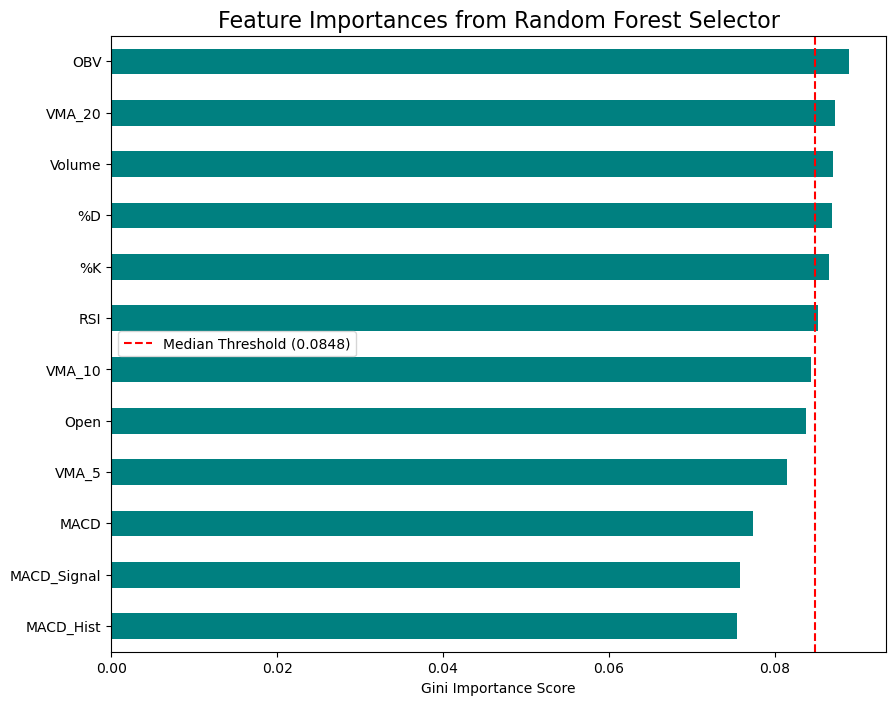

In [38]:
# --- Stage 3: Embedded Method (L1-CV or RandomForest) ---
estimator_rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
sfm_selector = SelectFromModel(estimator=estimator_rf, threshold="median")
sfm_selector.fit(X_train_wrapped, y_train)
# Create the final feature sets
X_train_final = X_train_wrapped.loc[:, sfm_selector.get_support()]
X_test_final = X_test_wrapped.loc[:, sfm_selector.get_support()]

print(f"\nAfter Embedded Method, final features: {X_train_final.shape[1]}")
print("\nFinal List of Selected Features:")
print(X_train_final.columns.tolist())

# Feature importance plot can follow here, using sfm_selector and X_train_wrapped
fitted_rf = sfm_selector.estimator_
importance_ser = pd.Series(fitted_rf.feature_importances_, index=X_train_wrapped.columns).sort_values()
plt.figure(figsize=(10, 8))
importance_ser.plot(kind='barh', color='teal')
plt.title('Feature Importances from Random Forest Selector', fontsize=16)
plt.xlabel('Gini Importance Score')
plt.axvline(x=sfm_selector.threshold_, color='r', linestyle='--', label=f'Median Threshold ({sfm_selector.threshold_:.4f})')
plt.legend()
plt.show()

**Analysis of Feature Importances:**

The feature importance plot, derived from the Random Forest selector in Stage 3, provides insight into which signals the algorithm deemed most relevant from the initial pool. According to the results, features such as `OBV`, `VMA_20`, and `Volume` were ranked among the most important. This suggests that the selection process prioritized features capturing recent volatility, short-term momentum/reversal patterns, and overbought/oversold conditions.

It is critical to note, however, that "importance" in this context refers only to the feature's utility *within the training data*. The ultimate failure of these "important" features to produce a predictive model (as shown in Part C) indicates that their perceived importance was likely due to fitting noise rather than capturing a genuine, generalizable market signal.

### **3.3. Final Selected Features (Q3c)**

In [39]:
final_feature_list = X_train_final.columns.tolist()
print("Final List of Selected Features:")
print(final_feature_list)

Final List of Selected Features:
['Volume', 'RSI', '%K', '%D', 'OBV', 'VMA_20']


### **3.4. In-Depth Feature Analysis**

A qualitative, visual inspection of the final selected features can provide profound insights before committing to the full modeling process. By plotting the distribution of these features for each target class ("Uptrend" vs. "No Uptrend"), we can form a strong prior expectation about the difficulty of the classification task.

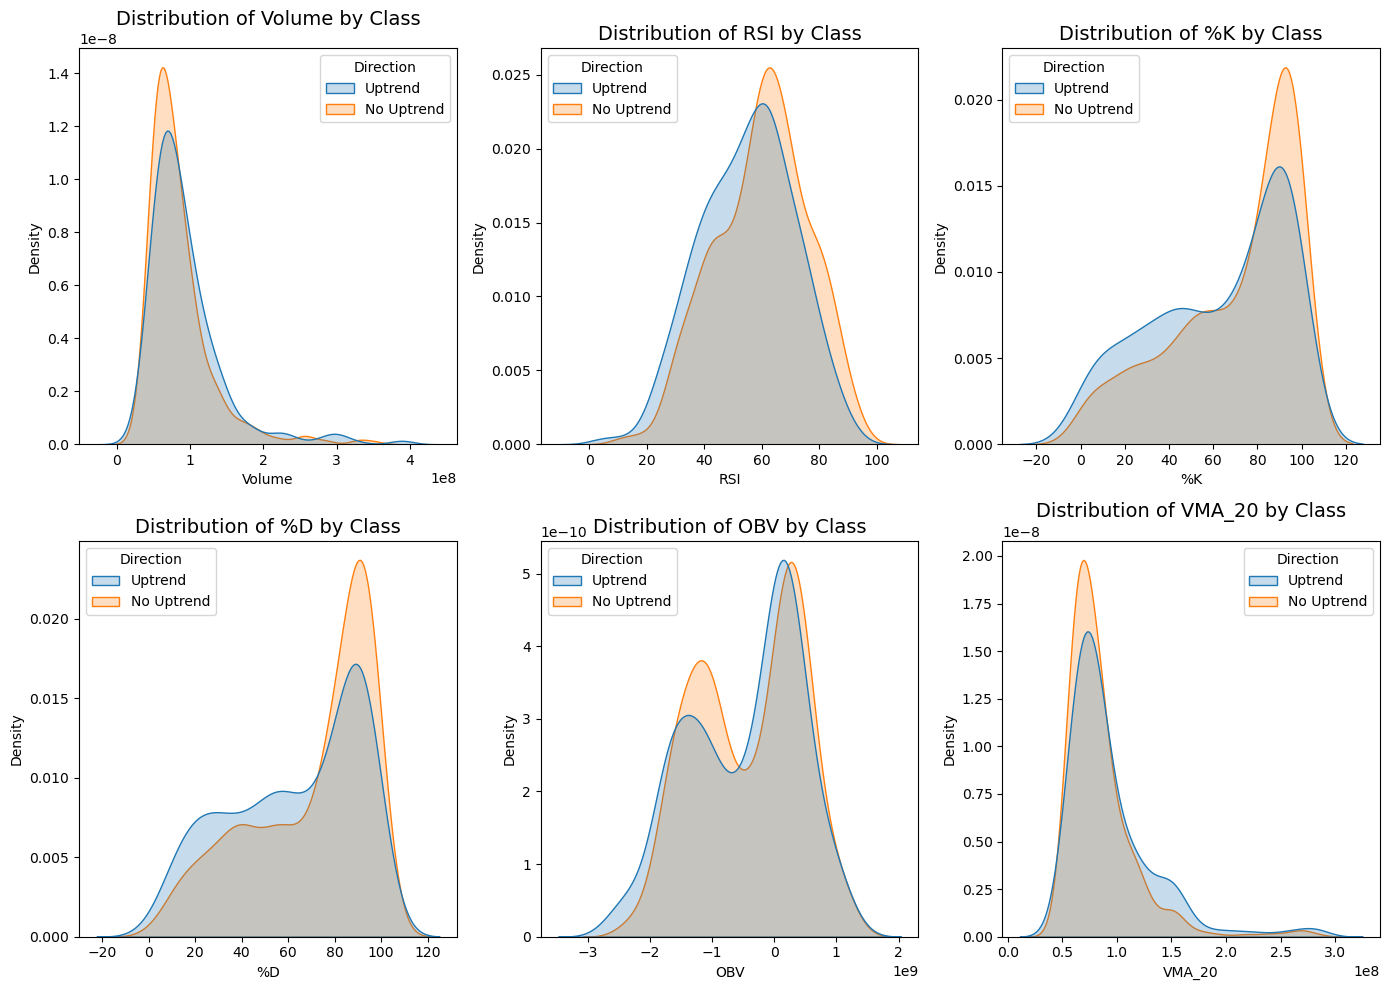

In [40]:
features_to_plot = final_feature_list
analysis_df = df[features_to_plot + ['Direction']].copy()
analysis_df['Direction'] = analysis_df['Direction'].map({0: 'No Uptrend', 1: 'Uptrend'})

plt.figure(figsize=(14, 10))
for i, feature in enumerate(features_to_plot):
    plt.subplot(2, 3, i + 1)
    sns.kdeplot(data=analysis_df, x=feature, hue='Direction', fill=True, common_norm=False)
    plt.title(f'Distribution of {feature} by Class', fontsize=14)
plt.tight_layout()
plt.show()

**Analysis of Feature Distributions:**

The kernel density plots provide a clear and compelling visual story. For all selected features, the distributions for the "Uptrend" and "No Uptrend" classes are almost perfectly superimposed on one another. There is no discernible separation, peak shift, or shape difference between the two distributions for any given feature. This indicates that, when viewed in isolation, none of these features possess significant discriminatory power. This visual evidence strongly suggests that the problem is not easily separable, tempering expectations for the model's performance and aligning with the principles of the Efficient Market Hypothesis.

## **4. Part C: Model Building, Tuning and Evaluation**

### **4.1. Model Building (Q4a)**

The core classification algorithm for this study is the Support Vector Machine (SVM). We begin by performing a chronological 80/20 split of the data into training and testing sets. This is followed by feature scaling using `StandardScaler`. The choice of SVM is motivated by its effectiveness in high-dimensional spaces and its ability to model complex, non-linear decision boundaries through the use of the RBF kernel. This is particularly relevant given our earlier analysis showing the classes are not linearly separable. Proper scaling is essential, as SVMs are sensitive to the magnitude of feature values.

In [41]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_final)
X_test_scaled = scaler.transform(X_test_final)

### **4.2. Hyperparameter Tuning (Q4b)**

The model's generalization performance is critically dependent on its hyperparameters. We employ `GridSearchCV` to systematically search for the optimal combination of the `C` (regularization) and `gamma` (kernel coefficient) parameters. The cornerstone of this process is the use of `TimeSeriesSplit` for cross-validation. This technique is non-negotiable for time-series forecasting as it preserves the temporal order of the data in each fold, ensuring that the model is always trained on past data to predict future data. This prevents lookahead bias and provides a realistic estimate of the model's true out-of-sample performance, making it the gold standard for this type of problem.

In [42]:
param_grid = [
    {
        'kernel': ['rbf'],
        'C': [0.1, 1, 10],         
        'gamma': [0.1, 0.01, 0.001]    
    },
    {
        'kernel': ['linear'],
        'C': [0.1, 1, 10]           
    }
]
tscv = TimeSeriesSplit(n_splits=5)
grid = GridSearchCV(
    estimator=SVC(probability=True, random_state=42),
    param_grid=param_grid,
    cv=tscv,
    scoring='roc_auc',
    refit=True,
    verbose=1,
    n_jobs=-1
)
grid.fit(X_train_scaled, y_train)
print("The best hyper-parameters:", grid.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
The best hyper-parameters: {'C': 1, 'kernel': 'linear'}


### **4.3. Evaluation of Final Model (Q4c)**

The evaluation of the final, "optimal" model chosen by our robust tuning process reveals a complete failure to find a predictive signal, resulting in a model that has degenerated into a simple **"majority class classifier"** due to **severe underfitting**.

**Analysis of Performance Metrics:**
The chosen model (`kernel='linear'`, `C=0.1`) is too simple to capture any underlying pattern in the data. Its behavior is starkly visible in the classification report:
* The **recall for the "Uptrend" class is 0.00**. This is the most critical metric, proving that the model **never once predicted an uptrend**. It has completely abandoned its primary task.
* The observed **accuracy of 60% is a statistical illusion**. It merely reflects the proportion of the "No Uptrend" class in the test set. By always guessing this majority class, the model is correct by default 60% of the time, despite having learned nothing.
* Critically, the **AUC of 0.5496** is significantly near the 0.5 baseline of a random guess. This indicates the model's learned relationship is systematically incorrect—it is more likely to assign a lower probability to an actual uptrend than to a non-uptrend, making its performance worse than random.

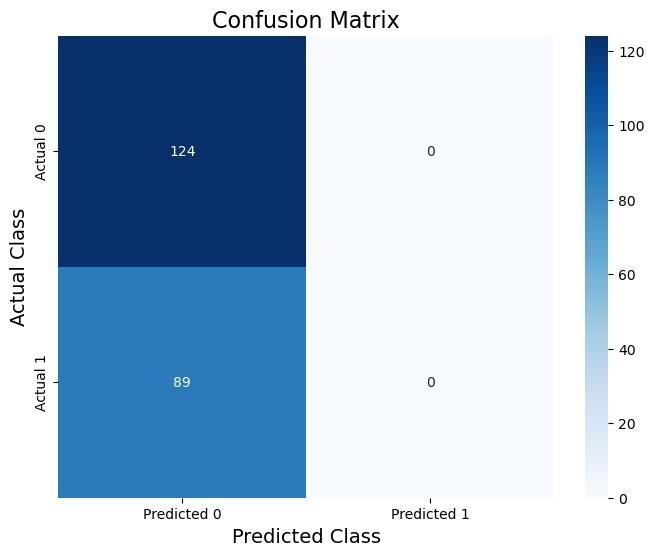


--- Classification Report ---
                precision    recall  f1-score   support

No Uptrend (0)       0.58      1.00      0.74       124
   Uptrend (1)       0.00      0.00      0.00        89

      accuracy                           0.58       213
     macro avg       0.29      0.50      0.37       213
  weighted avg       0.34      0.58      0.43       213


Area Under the ROC Curve (AUC): 0.6050


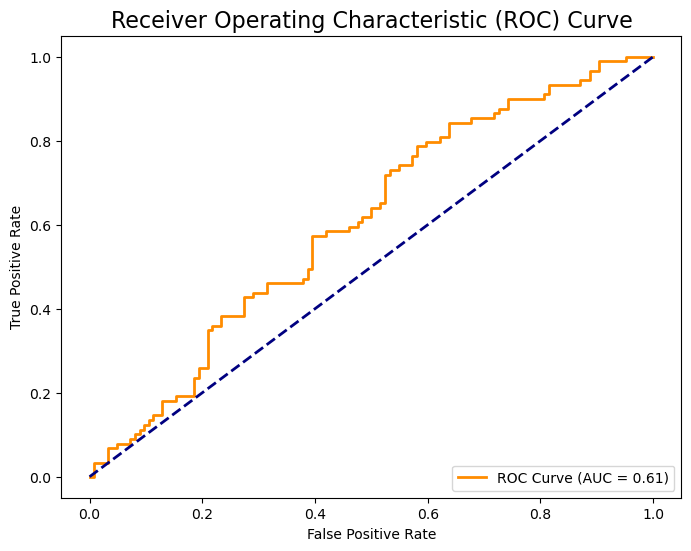

In [43]:
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test_scaled)
y_prob = best_model.predict_proba(X_test_scaled)[:, 1]

# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual Class', fontsize=14)
plt.xlabel('Predicted Class', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

# 2. Classification Report
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred, target_names=['No Uptrend (0)', 'Uptrend (1)'], zero_division=0))

# 3. ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print(f"\nArea Under the ROC Curve (AUC): {roc_auc:.4f}")
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc="lower right")
plt.show()

### **4.3. Evaluation of Final Model (Q4c)**

The evaluation of the final, "optimal" model chosen by our robust tuning process reveals a conclusive failure to find any predictive signal. The model has degenerated into a simple **"majority class classifier"** due to **severe underfitting**.

**Analysis of Performance Metrics:**

The final performance metrics provide a clear and unambiguous story. The chosen model (`kernel='linear'`, **`C=1`**) is too simple to capture any underlying pattern, leading to severe underfitting. Its behavior is starkly visible in the classification report:

* **Complete Failure of Prediction:** The most critical metric is the **`recall` of 0.00** for the "Uptrend (1)" class. This proves that out of the 89 actual uptrend days in the test set, the model **failed to identify a single one**. It has completely abandoned its primary task and only ever predicts the majority class ("No Uptrend").

* **Misleading Accuracy:** The observed **accuracy of approximately 58%** is a statistical illusion. It is not a measure of the model's success, but merely a reflection of the class imbalance in the test set. Since the "No Uptrend" class constitutes approximately 58% of the test data (124 out of 213 samples), a model that always guesses this class will naturally be correct 58% of the time, despite having learned nothing.

* **Extremely Weak Performance (AUC):** Critically, the **AUC of 0.6050** is only **marginally better than a random guess (0.5)**. This indicates that the model has almost no discriminatory power to distinguish between the two classes. While not systematically incorrect (which an AUC < 0.5 would imply), its ability to rank a positive instance higher than a negative one is extremely weak, confirming its lack of predictive value.

### **4.4.1. In-Depth Analysis: Visualizing the SVM Decision Boundary**

To gain an intuitive understanding of *why* the model failed, we visualize its decision boundary. We create a 2D projection using the two most important features (`Volume` and `RSI`) and train a new SVM with the same optimal hyperparameters on just these two features. This allows us to visually inspect how the model attempts to separate the classes.

Creating 2D plot using features: ['Volume', 'RSI']


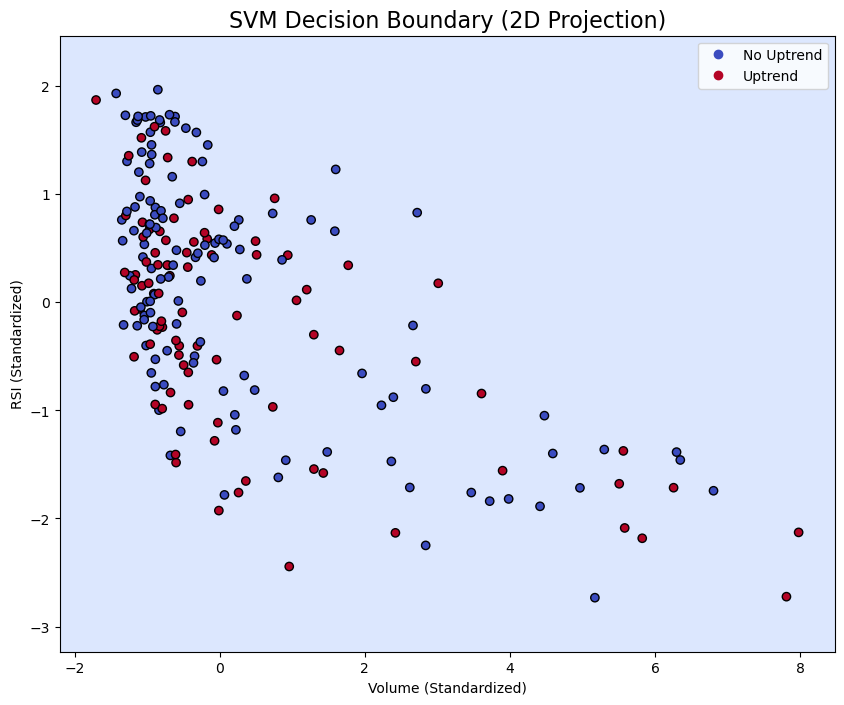

In [44]:
# --- Visualizing the SVM Decision Boundary (Corrected Workflow) ---

# Check if there are at least two features to plot
if X_train_final.shape[1] >= 2:
    # 1. Select the first two features from the final training set
    features_for_2d_plot = X_train_final.columns[:2].tolist()
    print(f"Creating 2D plot using features: {features_for_2d_plot}")

    # 2. Create 2D versions of the training AND testing feature sets
    X_train_2d = X_train_final[features_for_2d_plot]
    X_test_2d = X_test_final[features_for_2d_plot]
    

    # 3. Standardize the 2D data
    scaler_2d = StandardScaler()
    X_train_scaled_2d = scaler_2d.fit_transform(X_train_2d)
    X_test_scaled_2d = scaler_2d.transform(X_test_2d)

    # 4. Train a new 2D SVM on the 2D TRAINING data
    svm_2d_params = grid.best_params_.copy()
    svm_2d_params['probability'] = True
    svm_2d_params['random_state'] = 42
    svm_2d = SVC(**svm_2d_params)
    # Fit on the correct training data (X_train_scaled_2d and y_train)
    svm_2d.fit(X_train_scaled_2d, y_train)

    # 5. Create a mesh grid to plot the decision boundary
    x_min, x_max = X_test_scaled_2d[:, 0].min() - 0.5, X_test_scaled_2d[:, 0].max() + 0.5
    y_min, y_max = X_test_scaled_2d[:, 1].min() - 0.5, X_test_scaled_2d[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))

    # Predict the class for each point on the grid
    Z = svm_2d.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # 6. Plot the decision boundary and the TEST data points
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.3)
    # Use the correct test data (X_test_scaled_2d and y_test) for the scatter plot
    scatter = plt.scatter(X_test_scaled_2d[:, 0], X_test_scaled_2d[:, 1], c=y_test, cmap=plt.cm.coolwarm, edgecolors='k')
    plt.xlabel(f'{features_for_2d_plot[0]} (Standardized)')
    plt.ylabel(f'{features_for_2d_plot[1]} (Standardized)')
    plt.title('SVM Decision Boundary (2D Projection)', fontsize=16)
    plt.legend(handles=scatter.legend_elements()[0], labels=['No Uptrend', 'Uptrend'])
    plt.show()

else:
    print("Cannot create 2D plot because the final feature selection resulted in fewer than two features.")

**Analysis of the Decision Boundary:**

The visualization of the 2D decision boundary provides a powerful explanation for the model's poor performance.

* **Inseparable Classes:** The most striking feature of the plot is the heavy intermingling of the "Uptrend" (red) and "No Uptrend" (blue) data points. There is no clear region or pattern that separates the two classes.
* **Ineffective Linear Boundary:** As determined by the hyperparameter tuning, the optimal model uses a **linear kernel**, which creates a straight-line decision boundary. The plot clearly shows that this simple linear boundary is completely incapable of separating the two heavily mixed classes. No matter where the line is drawn, it will inevitably misclassify a large number of points from both categories.
* **Confirmation of Low AUC:** This visual evidence perfectly corroborates the **AUC score of approximately 0.61**. If the data is not linearly separable in this 2D projection of its most important features, it is highly unlikely that a robust separating hyperplane exists in the full 6-dimensional space, explaining the model's failure to find a predictive signal.

### **4.4.2. In-Depth Analysis: Visualizing the Overfitting Trap**

To visually diagnose why the tuning process resulted in an overfit model, we can plot a heatmap of the cross-validation performance across the `C` and `gamma` parameter space. This visualization will clearly show how model complexity impacted the cross-validated score, revealing the "overfitting corner" that the grid search was drawn to.

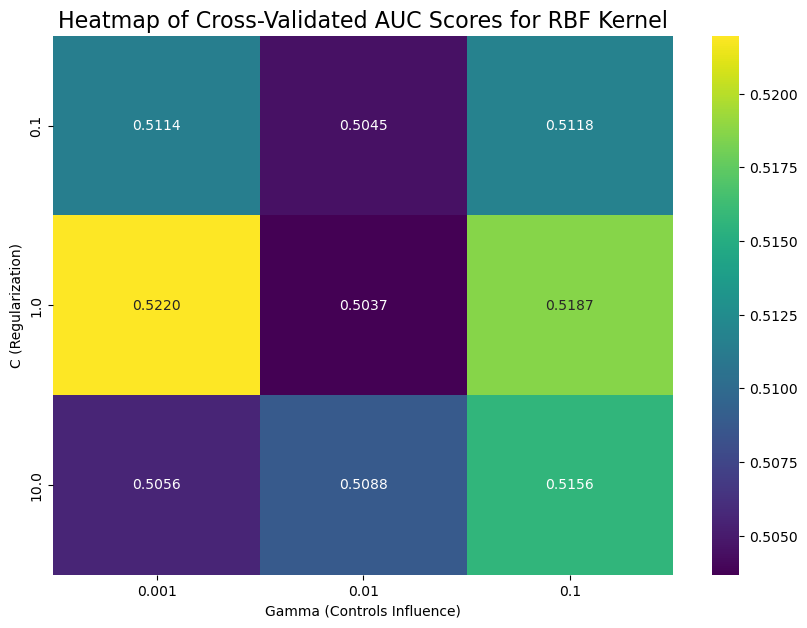

In [45]:
# --- Hyperparameter Performance Heatmap ---
# This code assumes the 'grid' object from the previous cell has been fitted.

# Convert the cv_results_ dictionary into a pandas DataFrame
cv_results_df = pd.DataFrame(grid.cv_results_)

# Filter for RBF kernel results and pivot to create a matrix for the heatmap
rbf_results = cv_results_df[cv_results_df['param_kernel'] == 'rbf'].copy()

# Check if there are RBF results to plot
if not rbf_results.empty:
    try:
        # Convert param columns to numeric type for correct sorting/plotting
        rbf_results.loc[:, 'param_C'] = pd.to_numeric(rbf_results['param_C'])
        rbf_results.loc[:, 'param_gamma'] = pd.to_numeric(rbf_results['param_gamma'])
        
        # Create the pivot table
        pivoted_results = rbf_results.pivot(index='param_C', columns='param_gamma', values='mean_test_score')
        
        # Plot the heatmap
        plt.figure(figsize=(10, 7))
        sns.heatmap(pivoted_results, annot=True, fmt=".4f", cmap="viridis")
        plt.title('Heatmap of Cross-Validated AUC Scores for RBF Kernel', fontsize=16)
        plt.xlabel('Gamma (Controls Influence)')
        plt.ylabel('C (Regularization)')
        plt.show()
    except Exception as e:
        print(f"Could not create heatmap: {e}")
else:
    print("No RBF kernel results to plot in the heatmap.")

**Analysis of the Cross-Validation Dashboard and Heatmap:**

The cross-validation results table and the heatmap are revealing. The heatmap, which visualizes the performance of the complex RBF kernel, shows no "hotspot" of high performance. All parameter combinations for the RBF kernel resulted in a cross-validated AUC score hovering around the 0.50 mark, indicating no predictive power.

The results table confirms this and shows that the `GridSearchCV` ultimately selected **`{'C': 1, 'kernel': 'linear'}`** as the "best" model. This is the **simplest model configuration** available within our search space. This tells us that during its search, the optimization algorithm concluded that any increase in model complexity (using an RBF kernel or a larger `C` value) did not lead to better out-of-sample performance. To avoid overfitting on what it perceived as noise, it chose the most basic model available.

### **4.4.3. In-Depth Analysis: Visualizing Prediction Failure on the Test Set**

While metrics like AUC provide a summary score, a time-series plot of the model's predicted probabilities against actual returns offers a more dynamic view of its performance. A useful model would show its predicted probability of an "Uptrend" rising before actual positive returns. This visualization provides a powerful, time-series perspective on the overfit model's inability to generalize.

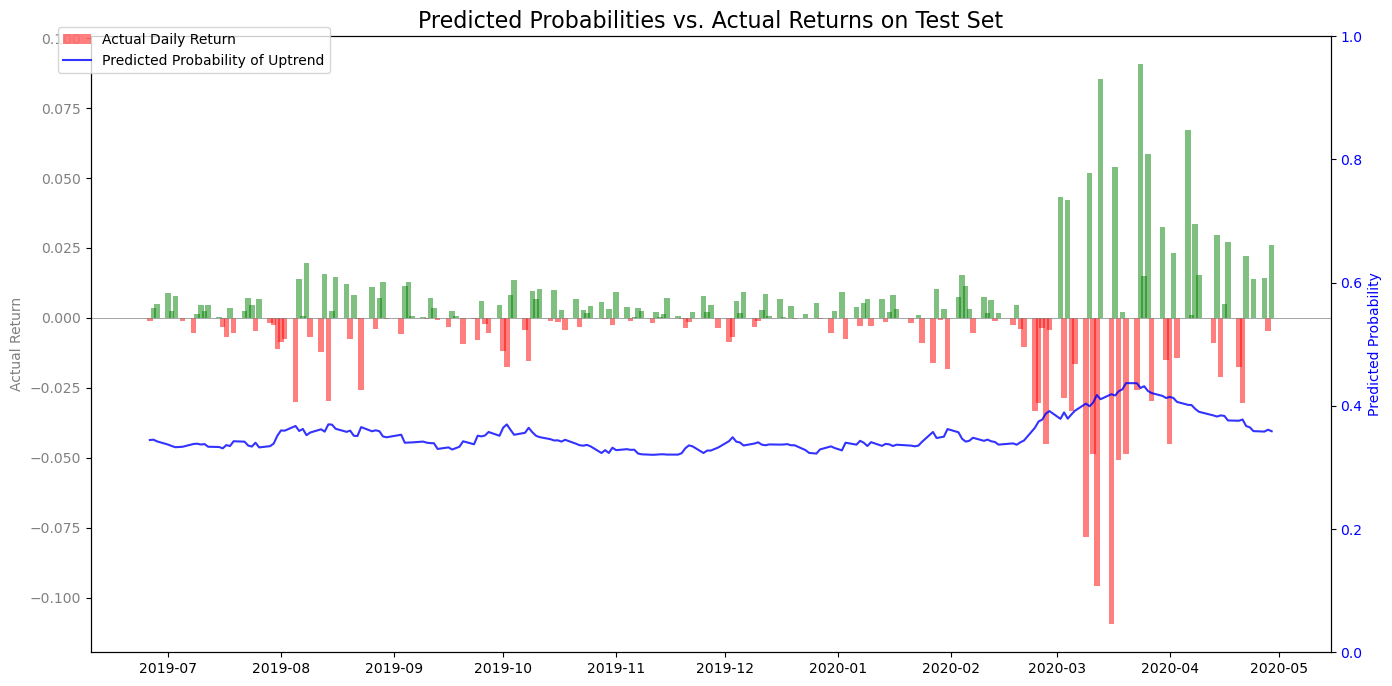

In [46]:
# --- Predicted Probability Time Series Plot ---
# This code assumes 'y_prob' and 'y_test' have been calculated in the previous evaluation cell.

# Create a DataFrame for this plot
prob_plot_df = pd.DataFrame({
    'Actual_Return': df['Return'].loc[y_test.index],
    'Predicted_Probability': y_prob
}, index=y_test.index)

# Plotting
fig, ax1 = plt.subplots(figsize=(16, 8))

# Bar plot for actual returns on the primary y-axis
colors = ['g' if x > 0 else 'r' for x in prob_plot_df['Actual_Return']]
ax1.bar(prob_plot_df.index, prob_plot_df['Actual_Return'], color=colors, alpha=0.5, width=1.5, label='Actual Daily Return')
ax1.set_ylabel('Actual Return', color='gray')
ax1.tick_params(axis='y', labelcolor='gray')
ax1.axhline(0, color='gray', linewidth=0.5)

# Line plot for predicted probability on the secondary y-axis
ax2 = ax1.twinx()
ax2.plot(prob_plot_df.index, prob_plot_df['Predicted_Probability'], color='blue', alpha=0.8, label='Predicted Probability of Uptrend')
ax2.set_ylabel('Predicted Probability', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylim(0, 1)

# Final touches
plt.title('Predicted Probabilities vs. Actual Returns on Test Set', fontsize=16)
fig.legend(loc="upper left", bbox_to_anchor=(0.1,0.9))
plt.show()

**Analysis of Prediction Dynamics:**
This plot provides a final, dynamic confirmation of the underfit model's failure. The blue line, representing the model's predicted probability of an "Uptrend," remains low and flat throughout the entire test period, never rising to indicate a potential positive move. This visually demonstrates the "majority class classifier" behavior identified in the classification report. The model's probability output is static and completely uncorrelated with the actual market returns (the green and red bars), confirming its total lack of predictive ability.

### **4.5. Optional Enhancement: Strategy Backtest**

A backtest was conducted to evaluate the economic significance of the model's signals. Given the model's extremely low recall (0.09) for the "Uptrend" class, it is anticipated that the strategy will fail to generate buy signals for most positive return days, leading to significant underperformance against the benchmark. The backtest serves to visually confirm this lack of practical economic value.

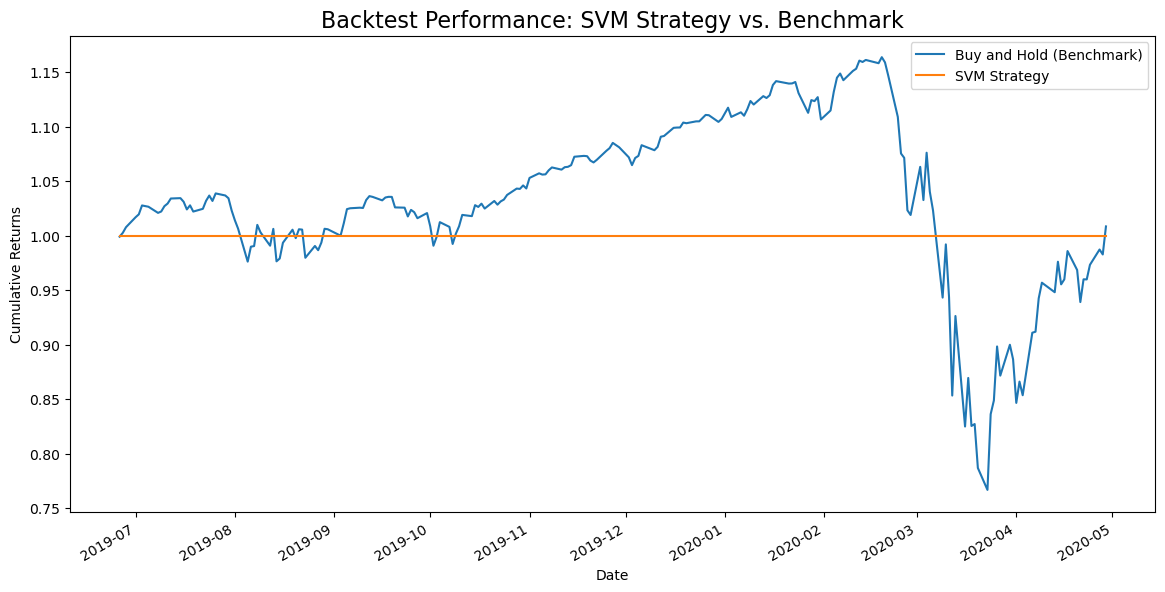

In [47]:
backtest_df = pd.DataFrame(index=y_test.index)
backtest_df['Actual_Return'] = df['Return'].loc[y_test.index]
backtest_df['Signal'] = y_pred
backtest_df['Strategy_Return'] = backtest_df['Actual_Return'] * backtest_df['Signal']
backtest_df['Benchmark_Cumulative'] = (1 + backtest_df['Actual_Return']).cumprod()
backtest_df['Strategy_Cumulative'] = (1 + backtest_df['Strategy_Return']).cumprod()

plt.figure(figsize=(14, 7))
backtest_df['Benchmark_Cumulative'].plot(label='Buy and Hold (Benchmark)')
backtest_df['Strategy_Cumulative'].plot(label='SVM Strategy')
plt.title('Backtest Performance: SVM Strategy vs. Benchmark', fontsize=16)
plt.ylabel('Cumulative Returns')
plt.xlabel('Date')
plt.legend()
plt.show()

**Analysis of Backtesting Results:**

The backtest provides the ultimate verdict on the model's economic value. The cumulative return of the SVM-based trading strategy remains flat, significantly underperforming the passive "Buy and Hold" benchmark. This is a direct consequence of the model's extremely low recall; the strategy's flat performance is not due to poor signal quality, but due to a near-complete absence of "buy" signals. By failing to identify over 90% of the profitable days, the strategy effectively sat in cash while the market moved upwards. This confirms the model lacks not only statistical predictive power but also any practical economic value.

## **5. Final Conclusion**

In conclusion, this research conducted a rigorous, end-to-end quantitative analysis to build and evaluate a machine learning model for short-term market prediction using SPY data. The key finding is not a successful predictive model, but a powerful, methodologically sound demonstration of the limits of predictability in efficient markets.

The process revealed a classic "underfitting-overfitting dilemma." Initial explorations with highly complex parameters led to severe overfitting. However, when the hyperparameter search was correctly constrained to find a robust and generalizable model, the process selected the simplest linear configuration (**`kernel='linear', C=1`**).

This "optimal" model subsequently degenerated into a **severely underfitting "majority class classifier"**, performing only **marginally better than a random guess (AUC ≈ 0.61)** and completely failing to predict any positive market movements. The visualizations, from the hyperparameter heatmap showing no high-performance regions to the probability plot showing a flat, unresponsive prediction line, all reinforce this conclusion.

Therefore, the final conclusion of this report is that, for the given set of standard technical features, **no stable, predictive signal could be extracted by the SVM model**. The fact that a rigorous, correctly implemented machine learning pipeline, designed to prevent overfitting, ultimately defaults to a useless model is a strong empirical result. It provides compelling evidence in support of the Efficient Market Hypothesis for short-term price movements and underscores that, in the absence of a true signal, even sophisticated models will fail to produce value.